# CICERO SCM notebook - parallel application

Import some stuff

In [1]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt
import warnings
import logging

try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", message=".*Parameter.*")

In [2]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

In [3]:
import concurrent

In [4]:
from ciceroscm.parallel._configdistro import _ConfigDistro
from ciceroscm.parallel.calibrator import Calibrator
from ciceroscm.parallel.distributionrun import DistributionRun


/uio/kant/div-cicero-u1/bensan/ciceroscm-1/venv/lib/python3.8/site-packages/scmdata/database/_database.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman
/uio/kant/div-cicero-u1/bensan/ciceroscm-1/venv/lib/python3.8/site-packages/setuptools_scm/_integration/setuptools.py:31: RuntimeWarning: 
ERROR: setuptools==47.1.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


<IPython.core.display.Javascript object>

Import the model

In [5]:
sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM

Define some input handling functions to give us example inputs

In [6]:
from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions

Define a function to convert model output to a dataframe

set up input directories

In [7]:
test_data_dir = os.path.join(os.getcwd(), '../', 'tests', 'test-data')

# Read in datafiles into dataframes

In [8]:
# NBVAL_IGNORE_OUTPUT
#Read gas parameters
gaspam =read_components(test_data_dir + '/gases_v1RCMIP.txt')
gaspam.head()

,EM_UNIT,CONC_UNIT,BETA,ALPHA,TAU1,TAU2,TAU3,NAT_EM,SARF_TO_ERF
GAS,,,,,,,,,
CO2,Pg_C,ppm,2.123,0.00000,150.00,0,0,0.0,1.000000
CH4,Tg,ppb,2.780,0.00000,9.60,120,160,275.0,0.877193
N2O,Tg_N,ppb,4.810,0.00000,121.00,0,0,9.5,1.000000
SO2,Tg_S,-,11.000,0.00000,0.02,0,0,0.0,1.000000
CFC-11,Gg,ppt,22.600,0.00026,45.00,0,0,0.0,1.000000


Read natural emissions

In [9]:
# NBVAL_IGNORE_OUTPUT
df_nat_ch4 =read_natural_emissions(test_data_dir + '/natemis_ch4.txt','CH4')
df_nat_n2o =read_natural_emissions(test_data_dir + '/natemis_n2o.txt','N2O')
df_nat_ch4.head()


,CH4
year,
1750,269.4273
1751,270.9068
1752,273.0183
1753,272.0470
1754,271.1915


Read forcing

In [10]:
df_ssp2_conc =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
df_ssp2_conc.head()

,CO2,CH4,N2O,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,CH3Br,CCl4,...,HFC143a,HFC227ea,HFC23,HFC245fa,HFC32,HFC4310mee,C2F6,C6F14,CF4,SF6
Component,,,,,,,,,,,,,,,,,,,,,
1700,276.746000,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1701,276.749995,706.247004,272.243047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1702,276.757998,706.375031,272.266047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1703,276.757001,706.491002,272.298047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1704,276.755000,706.602046,272.331052,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0


In [11]:
emi_input =read_inputfile(test_data_dir + '/ssp245_em_RCMIP.txt')
emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)
emi_input.head()

,CO2_FF,CO2_AFOLU,CH4,N2O,SO2,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,...,CF4,SF6,NOx,CO,NMVOC,NH3,BMB_AEROS_BC,BMB_AEROS_OC,BC,OC
Component,,,,,,,,,,,,,,,,,,,,,
1750,0.002592,0.081127,19.019783,0.054710,1.222464,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.927690,1.353250,12.520269,0.744520,2.927399
1751,0.002593,0.082619,18.915109,0.055744,1.206598,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828060,343.926367,59.088126,6.860142,1.335274,12.279280,0.737652,2.909437
1752,0.002594,0.084139,18.889712,0.056797,1.200955,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828658,341.809034,58.631997,6.819482,1.326617,12.121816,0.737695,2.912659
1753,0.002594,0.085687,19.121377,0.057870,1.207757,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.812105,343.675456,59.026349,6.881439,1.328560,12.249330,0.743391,2.933215
1754,0.002595,0.087263,19.509061,0.058963,1.233495,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.841598,349.815625,60.269945,7.015189,1.346553,12.593635,0.752796,2.965138


# Set up model run with defined input variables

In [12]:
scendata={
            "gaspam_data": gaspam,
            "emstart": 1750,  
            "conc_run":False,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_ssp2_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
            "udir": test_data_dir,
            "scenname": "ssp245",
        }

In [13]:
    calibdata = pd.DataFrame(
        data={
            "Variable Name": [
                "Heat Content|Ocean",
                "Surface Air Ocean Blended Temperature Change",
            ],
            "Yearstart_norm": [1971, 1961],
            "Yearend_norm": [1971, 1990],
            "Yearstart_change": [2018, 2000],
            "Yearend_change": [2018, 2019],
            "Central Value": [320.69251537323, 0.5372],
            "sigma": [17.020342912051203, 0.039028311931729676],
        })

In [14]:
    testconfig = _ConfigDistro(
        distro_array=np.array([[0, 1], [0, 1], [0, 1], [4, 6]]),
        setvalues={
            "qbmb": 0,
            "qo3": 0.5,
            "threstemp": 7.0,
            "lm": 40,
            "ldtime": 12,
        },
    )

In [15]:
testconfig.ordering

['rlamdo',
 'akapa',
 'cpi',
 'W',
 'beto',
 'lambda',
 'mixed',
 'qdirso2',
 'qindso2',
 'qbc',
 'qoc',
 'beta_f',
 'mixed_carbon',
 'qh2o_ch4']

In [16]:
# NBVAL_IGNORE_OUTPUT
scen = 'test'
cscm_dir=CICEROSCM({
            "gaspam_data": gaspam,
            "emstart": 1750,  
            "conc_run":False,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_ssp2_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
        })

In [20]:
distrorun1 = DistributionRun(testconfig, numvalues=50000)
output_vars = ["Heat Uptake", "Surface Air Temperature Change"]


[ 0.          0.          0.          4.          0.          0.53908356
 25.         -0.55       -1.5         0.1        -0.1         0.11
 25.          0.08      ]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  6.00000000e+00
  7.00000000e+00  1.34770889e+00  1.25000000e+02 -2.00000000e-01
 -5.00000000e-01  2.00000000e-01 -6.00000000e-02  4.65000000e-01
  1.25000000e+02  1.00000000e-01]


In [21]:
def get_results(cfg):
    try:
        cscm_dir._run({"results_as_dict": True},pamset_udm=cfg['pamset_udm'],pamset_emiconc=cfg['pamset_emiconc'])
        res=cscm_dir.results

    except:
        res=None
    return [cfg,res]

In [22]:
def run_parallel(cfgs,nworkers=4):
    results=len(cfgs)*[None]
    with ProcessPoolExecutor(nworkers) as exe:
            # execute tasks concurrently and process results in order
            pres=list(tqdm(exe.map(get_results, cfgs)))
            for result in pres:
                # get the corresponding index of the config
                ind=int(result[0]['Index'])
                # put it in the right element of the results vector
                results[ind]=result[1]
    return results

In [23]:
results=run_parallel(distrorun1.cfgs,nworkers=200)

612it [00:16, 21.67it/s] /uio/kant/div-cicero-u1/bensan/ciceroscm-1/src/ciceroscm/upwelling_diffusion_model.py:427: RuntimeWarning: overflow encountered in double_scalars
  self.varrying["dtrm1n"] * self.tn[0]
/uio/kant/div-cicero-u1/bensan/ciceroscm-1/src/ciceroscm/upwelling_diffusion_model.py:433: RuntimeWarning: overflow encountered in double_scalars
  self.varrying["dtrm1s"] * self.ts[0]
/uio/kant/div-cicero-u1/bensan/ciceroscm-1/src/ciceroscm/upwelling_diffusion_model.py:451: RuntimeWarning: overflow encountered in double_scalars
  + self.varrying["dtmnl2"] * self.tn[0]
/uio/kant/div-cicero-u1/bensan/ciceroscm-1/src/ciceroscm/upwelling_diffusion_model.py:456: RuntimeWarning: overflow encountered in double_scalars
  + self.varrying["dtmsl2"] * self.ts[0]
9341it [04:02, 39.02it/s]/uio/kant/div-cicero-u1/bensan/ciceroscm-1/src/ciceroscm/upwelling_diffusion_model.py:427: RuntimeWarning: overflow encountered in double_scalars
  self.varrying["dtrm1n"] * self.tn[0]
/uio/kant/div-cicero-

In [24]:
flds=['dT_glob','OHCTOT','concentrations-CO2','RIB_glob']

In [26]:
isgd=np.where([r!=None for r in results])[0].astype(int)

In [27]:
fresults = [results[i] for i in isgd]
fcfgs=[distrorun1.cfgs[i] for i in isgd]

In [28]:
def to_df(rs):

    out=pd.concat([pd.DataFrame(v).reset_index(drop=True) for k, v in rs.items()], keys = rs.keys(),axis=1) 
    out.index=rs['forcing'].index
    return out

In [29]:
def make_ensdf(results,flds):
    resdf=[]
    for i,res in enumerate(results):
        df=to_df(res)
        test_list=df.columns.map('{0[0]}-{0[1]}'.format).tolist()
        df.columns=[sub.replace('-0', '') for sub in test_list]
        resdf.append(df[flds].unstack())
    ensdf=pd.concat(resdf,axis=1)
    return ensdf

In [30]:
df=make_ensdf(fresults,flds)

In [32]:
issane=np.where(df.max()<1e8)[0]

In [34]:
df

0         1         2         3         4         5      \
dT_glob  1750  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         1751  0.000149  0.000216  0.000121  0.000137  0.000180  0.000214   
         1752  0.000522  0.000784  0.000433  0.000492  0.000647  0.000771   
         1753  0.000940  0.001466  0.000809  0.000910  0.001198  0.001437   
         1754  0.001322  0.002126  0.001190  0.001322  0.001732  0.002112   
...                 ...       ...       ...       ...       ...       ...   
RIB_glob 2096  2.318666  2.625350 -2.573489  1.907810  2.739221  1.716201   
         2097  2.310374  2.618286 -2.606564  1.895557  2.730707  1.702385   
         2098  2.301911  2.611035 -2.638890  1.883191  2.721980  1.688481   
         2099  2.293261  2.603584 -2.670479  1.870698  2.713024  1.674473   
         2100  2.284420  2.595925 -2.701335  1.858070  2.703835  1.660356   

                  6         7         8         9      ...     49983  \
dT_glob  1750  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
         1751  0.000182  0.000127  0.000166  0.000186  ...  0.000105   
         1752  0.000657  0.000465  0.000617  0.000679  ...  0.000392   
         1753  0.001218  0.000877  0.001183  0.001282  ...  0.000743   
         1754  0.001766  0.001282  0.001754  0.001886  ...  0.001102   
...                 ...       ...       ...       ...  ...       ...   
RIB_glob 2096  2.774133  2.167723  1.994252  1.735891  ...  2.676529   
         2097  2.766767  2.160511  1.987791  1.727476  ...  2.667821   
         2098  2.759187  2.153175  1.981234  1.719005  ...  2.658879   
         2099  2.751380  2.145700  1.974559  1.710458  ...  2.649693   
         2100  2.743340  2.138078  1.967754  1.701823  ...  2.640257   

                  49984     49985     49986     49987     49988     49989  \
dT_glob  1750  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         1751  0.000175  0.000157  0.000156  0.000156  0.000143  0.000200   
         1752  0.000625  0.000536  0.000546  0.000589  0.000497  0.000723   
         1753  0.001153  0.000945  0.000992  0.001131  0.000896  0.001362   
         1754  0.001661  0.001309  0.001414  0.001702  0.001268  0.002003   
...                 ...       ...       ...       ...       ...       ...   
RIB_glob 2096  2.132872  3.366888  2.725714  2.536649  1.995282  1.393863   
         2097  2.122885  3.362316  2.717553  2.526345  1.984530  1.379471   
         2098  2.112767  3.357431  2.709197  2.515855  1.973646  1.365075   
         2099  2.102499  3.352222  2.700633  2.505164  1.962614  1.350655   
         2100  2.092075  3.346687  2.691857  2.494268  1.951429  1.336200   

                  49990     49991     49992  
dT_glob  1750  0.000000  0.000000  0.000000  
         1751  0.000183  0.000211  0.000134  
         1752  0.000629  0.000709  0.000475  
         1753  0.001124  0.001233  0.000864  
         1754  0.001571  0.001682  0.001239  
...                 ...       ...       ...  
RIB_glob 2096  2.733807  2.295511  3.342750  
         2097  2.724897  2.287334  3.338468  
         2098  2.715761  2.278985  3.333897  
         2099  2.706383  2.270448  3.329023  
         2100  2.696760  2.261719  3.323845  

[1404 rows x 49993 columns]

In [35]:
df1 = df.iloc[:,issane]
fcfgs1=[fcfgs[i] for i in issane]

In [37]:
df1.index.names = ['variable', 'year']
df1.columns.names=['run_id']

In [38]:
def plot_range(df, var, ax,col='k'):
    Tdf=df.xs(var).T
    lower = Tdf.quantile(0.10)
    upper = Tdf.quantile(0.90)
    ax.fill_between(Tdf.columns, lower, upper, color=col, alpha=0.2,edgecolor=None)
    ax.plot(Tdf.columns, Tdf.mean(), color=col)



(0.0, 5.0)

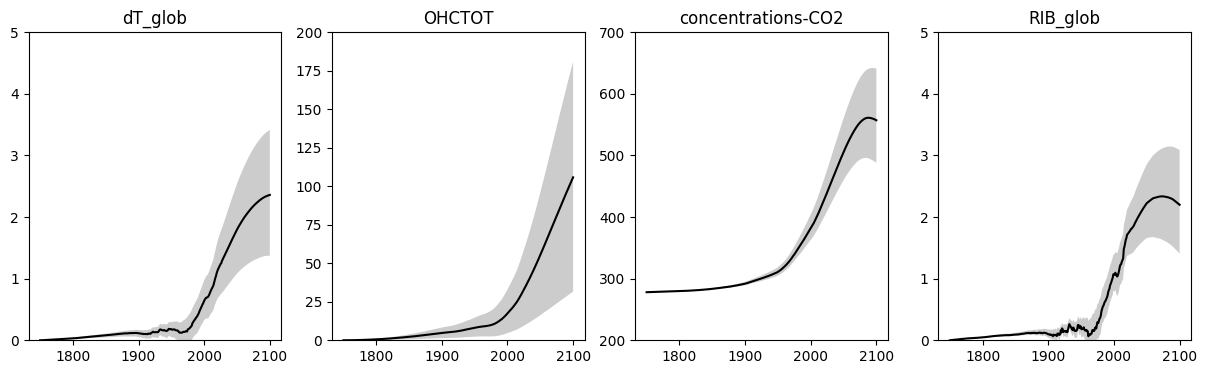

In [39]:
fig, ax = plt.subplots( 1,len(flds) ,figsize=(15, 4))

ax=ax.flatten()
for i,f in enumerate(flds):
    plot_range(df1, f, ax[i])
    ax[i].set_title(f)
ax[0].set_ylim([0,5])
ax[1].set_ylim([0,200])
ax[2].set_ylim([200,700])
ax[3].set_ylim([0,5])



In [40]:
dates=[1950,1970,1990,2005,2018]
targ=df1.loc[(slice(None), dates), :].T
nflds=targ.shape[1]


In [41]:
def merge_dicts(dc):
    """Given two dictionaries, merge them into a new dict as a shallow copy."""
    x=dc['pamset_udm']
    y=dc['pamset_emiconc']
    z = x.copy()
    z.update(y)
    return z

In [42]:
pdict=fcfgs1
mdict=[ merge_dicts(d) for d in pdict ]
pmat=pd.DataFrame(mdict)

In [44]:
parammat=pmat.loc[:, (pmat != pmat.iloc[0]).any()]
parammat

,rlamdo,akapa,cpi,W,beto,lambda,mixed,qdirso2,qindso2,qbc,qoc,beta_f,mixed_carbon,qh2o_ch4
0,0.440774,0.905520,0.800352,5.620841,0.752613,0.717799,68.615260,-0.544990,-1.142060,0.174110,-0.081630,0.326783,98.513488,0.092349
1,0.680958,0.404737,0.743800,5.617995,3.129197,1.197337,40.324068,-0.440564,-1.203002,0.136840,-0.076598,0.152043,65.726819,0.092525
2,0.454898,0.004942,0.367294,5.314021,1.806886,0.584156,94.649749,-0.293159,-1.073865,0.151952,-0.070529,0.204999,30.865822,0.092618
3,0.864660,0.936105,0.360483,5.480949,6.923262,0.846428,114.377980,-0.277504,-0.971991,0.114998,-0.082022,0.415251,83.888076,0.081175
4,0.548379,0.803303,0.517343,4.273653,2.332851,0.968192,50.594933,-0.279753,-1.204846,0.185195,-0.089575,0.248190,41.538023,0.081284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49986,0.480394,0.711929,0.482743,4.096088,4.151251,0.703563,93.237721,-0.504255,-0.955029,0.116901,-0.080561,0.326799,108.476461,0.089865
49987,0.893816,0.212135,0.105495,5.928718,0.530559,1.235700,73.692531,-0.474287,-1.340414,0.149180,-0.080990,0.325688,43.045798,0.095690
49988,0.473716,0.998920,0.287551,5.960427,1.206252,0.857163,58.998088,-0.452685,-1.353985,0.155642,-0.091753,0.135887,57.343110,0.087520
49989,0.185356,0.639269,0.597594,4.798626,6.282454,0.921124,109.239547,-0.455020,-1.262432,0.126494,-0.092564,0.435344,116.347524,0.098608


In [45]:
store = pd.HDFStore('data.h5')
store['targ'] = targ
store['parammat'] = parammat
store.close()

In [1]:
plt.plot(targ['dT_glob'][2018],pmat['lambda'],'.')

NameError: name 'plt' is not defined

In [67]:
from sklearn.model_selection import train_test_split
XTraining, XValidation, YTraining, YValidation = train_test_split(parammat,targ,test_size=0.1, shuffle=False) # before model building


In [68]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices())

2024-05-10 12:32:32.098984: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-10 12:32:32.214775: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-10 12:32:32.218088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 12:32:35.212623: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [69]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(30, activation='tanh'),
      layers.Dense(10, activation='tanh'),

      layers.Dense(nflds)
  ])

  model.compile(loss='mae',
                optimizer=tf.keras.optimizers.AdamW(0.001))
  return model

In [70]:
normalizer = tf.keras.layers.Normalization(input_shape=[parammat.shape[1],], axis=-1)

In [72]:
normalizer.adapt(parammat)

In [73]:
dnn_model = build_and_compile_model(normalizer)


In [74]:
X_train = tf.convert_to_tensor(XTraining, dtype=tf.float32)
Y_train = tf.convert_to_tensor(YTraining, dtype=tf.float32)
X_dev = tf.convert_to_tensor(XValidation, dtype=tf.float32)
Y_dev = tf.convert_to_tensor(YValidation, dtype=tf.float32)

In [75]:
from tqdm.keras import TqdmCallback

In [76]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [77]:
history=dnn_model.fit(X_train, Y_train, epochs=10000, batch_size=100, validation_data=(X_dev, Y_dev),verbose=0,callbacks=[TqdmCallback(verbose=0)])


0epoch [00:00, ?epoch/s]

KeyboardInterrupt: 

In [78]:
pred = dnn_model.predict(X_dev)
pred_t = dnn_model.predict(X_train)

282/282 [==============================] - 0s 905us/step


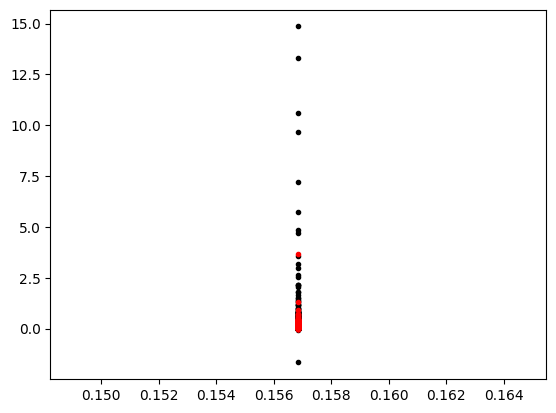

In [79]:
plt.plot(pred_t[:,0],Y_train[:,0],'k.')
plt.plot(pred[:,0],Y_dev[:,0],'r.')

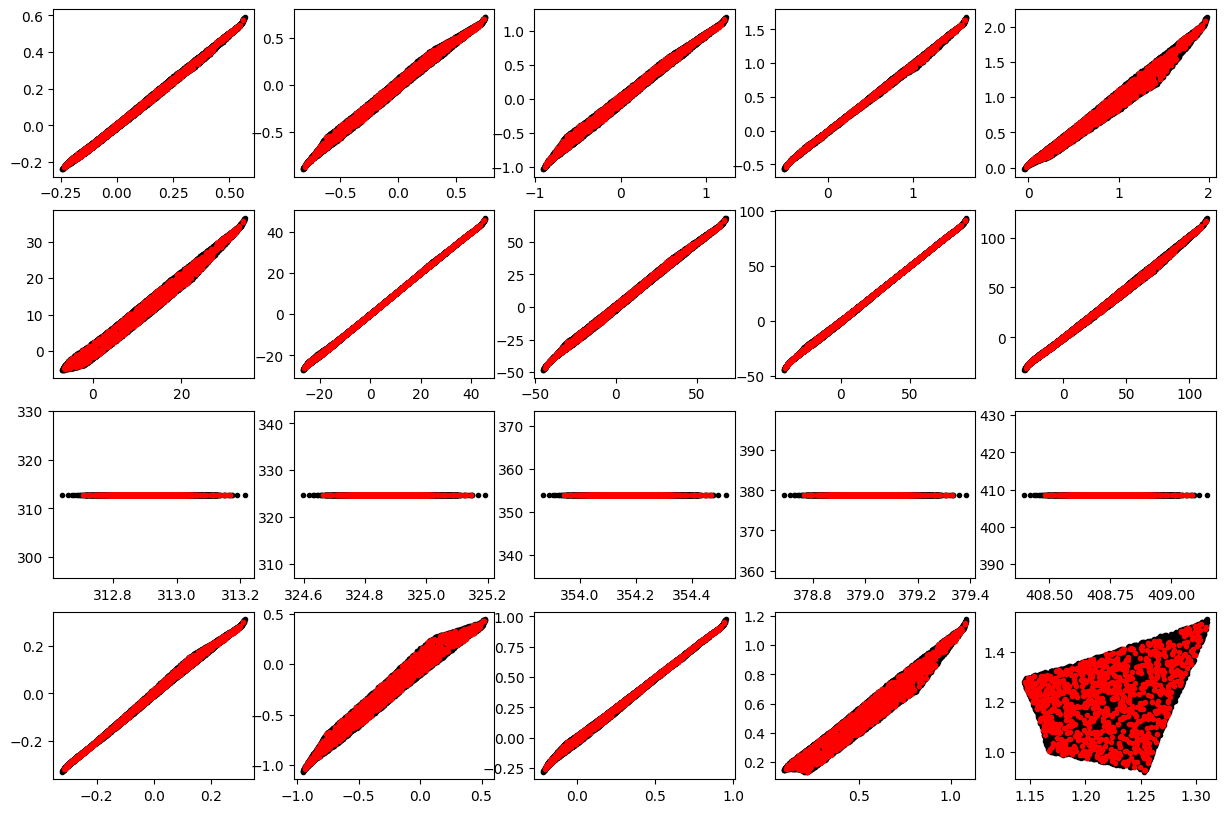

In [ ]:
fig, ax = plt.subplots( len(flds), len(dates),figsize=(15, 10))

ax=ax.flatten()
for i in np.arange(nflds):
  ax[i].plot(pred_t[:,i],Y_train[:,i],'k.')
  ax[i].plot(pred[:,i],Y_dev[:,i],'r.')

